 # Visualizing Large Scale Recordings
 
Now that we are familiar with the structure of an NWB file as well as the groups encapsulated within it, we are ready to work with the data. In this chapter you will learn to search the NWB file for its available data and plot visualizations such as raster plots.

Below, we'll import some now familiar packages and once again work with the dataset we obtained in [Chapter 2.1](https://neuraldatascience.github.io/Chapter_02/Obtaining_Datasets_with_DANDI.html).

In [1]:
# Import necessary packages
import h5py # version '2.10.0' is needed
import numpy as np
from matplotlib import pyplot as plt
from pynwb import NWBHDF5IO

# read the file 
io = NWBHDF5IO('000006/sub-anm369962/sub-anm369962_ses-20170310.nwb', 'r')
nwb_file = io.read()
print(type(nwb_file))

<class 'pynwb.file.NWBFile'>


The first group that we will look at is `units` because it contains information about spikes times in the data. This time, we will subset our dataframe to only contain neurons with `fair` spike sorting quality. This means that the researchers are more confident that these are indeed isolated neurons.  

In [3]:
# Get the units data frame
units_df = nwb_file.units.to_dataframe()
 
# Select only "Fair" units
desired_value = 'Fair'
fair_units_df = units_df[units_df['quality']==desired_value]

# Print the subsetted dataframe
fair_units_df.head()

,depth,quality,cell_type,spike_times,electrodes
id,,,,,
2,665.0,Fair,unidentified,"[329.95417899999956, 330.01945899999953, 330.0...",x y z imp \ id ...
5,715.0,Fair,unidentified,"[331.09961899999956, 332.14505899999955, 333.3...",x y z imp \ id ...
6,715.0,Fair,unidentified,"[329.91129899999953, 329.92869899999954, 330.0...",x y z imp \ id ...
7,765.0,Fair,unidentified,"[330.26357899999954, 330.3849389999996, 330.60...",x y z imp \ id ...
10,815.0,Fair,unidentified,"[329.8969389999996, 329.94389899999953, 329.95...",x y z imp \ id ...


The `spike_times` column contains the times at which the recorded neuron fired an actiion potential. Each neuron has a list of spike times for their `spike_times` column. 

In [4]:
# Return the first 10 spike times for your neuron of choice
unit_id = 5
print(units_df['spike_times'][unit_id][:10])

[331.099619 332.145059 333.362499 333.395059 334.149659 334.178019
 334.183059 334.612499 340.767066 340.916546]


A **spike raster plot** can be created using the function `plt.eventplot`. A spike raster plot displays the spiking of neurons over time. In a raster plot, each row corresponds to a different neuron or a different trial, and the x-axis represents the time. Each small vertical line in the plot represents the spiking of a neuron. Spike raster plots are useful as they reveal firing rate correlations between groups of neurons. For more information on `plt.eventplot` please visit the <a href = 'https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.eventplot.html'> matplotlib documentation</a>. 

Below, we'll create a function called `plot_raster()` that creates a raster plot from the `spike_times` column in `units`. `plot_raster()` takes the following arguments:

- `unit_df`: dataframe containing spike time data
- `neuron_start`: index of first neuron of interest 
- `neuron_end`: index of last neuron of interest
- `start_time`: start time for desired time interval 
- `end_time`: end time for desired time interval

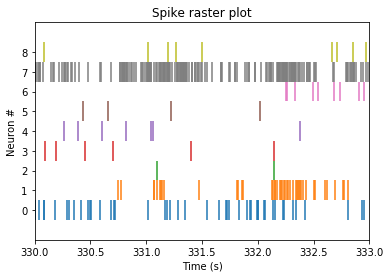

In [33]:
# Function for creating raster plots for Units group in NWB file 
def plot_raster(units_df,neuron_start,neuron_end,start_time,end_time):
    
    # Select the data 
    neural_data = units_df['spike_times'][neuron_start:neuron_end]
    
    # Calculate # of neurons
    num_neurons = neuron_end - neuron_start
    
    #Generate colors
    colors1 = ['C{}'.format(i) for i in range(num_neurons)] 
    
    # Plot our raster plot 
    plt.eventplot(neural_data,colors=colors1)

    # Set our axis limits to only include points in our data
    plt.xlim([start_time,end_time])
    
    # Label our figure 
    plt.title('Spike raster plot')
    plt.ylabel('Neuron #')
    plt.xlabel('Time (s)')
    plt.yticks(np.arange(0,num_neurons))

plot_raster(units_df, neuron_start = 2, neuron_end = 11, start_time = 330, end_time = 333)

# Show our plot 
plt.show()

The plot above is only contains neural spikes from a 3 second time interval. While there are many spikes to consider in this one graph, each neuron has much more than 3 seconds worth of spike recordings!

## Binning Firing Rates 

Raster plots are great for seeing individual neural spikes, but difficult to see the overall firing rates of the units. To get a better sense of the overall firing rates of our units, we can bin our spikes into time bins of 1 second. The function below, `plot_firing_rates()` take the following arguments:

- `spike_times`: *list* of spike times, in seconds
- `start_time`: start time for spike binning ; sets lower-most bound for x axis 
- `end_time`: end time for spike binning ; sets upper-most bound for x axis

The function plots the overall firing rate for each array of spike times in the list it is given, in 1 second time bins.

In [39]:
def plot_firing_rates(spike_times, start_time = None, end_time = None):
    
    # Assign total number of bins 
    numbins = int(np.ceil(spike_times[-1]))
    binned_spikes = np.empty((numbins))
  
    # Assign the frequency of spikes over time
    for j in range(numbins):
        binned_spikes[j] = len(spike_times[(spike_times>j)&(spike_times<j+1)])
          
    plt.plot(binned_spikes)
    plt.xlabel('Time (s)')
    plt.ylabel('Firing Rate (Hz)')
        
    if (start_time != None) and (end_time != None):
        plt.xlim(start_time, end_time)
        
    return 

Let's use the function we just created to plot our data. Below, we will store all of the spike times from the same unit as above as `single_unit` and plot the firing rates over time.

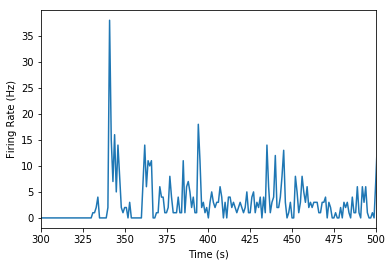

In [34]:
# Plot our data
single_unit = units_df['spike_times'][unit_id]
plot_firing_rates(single_unit,300,500)
plt.show()

## Compare firing rates at different depths of cortex

The units in our data were recorded from various cortical depths, therefore we can compare the firing units from differing cortical depths to test for differing firing rates. Let's first take a look at the distribution of depth from our units.

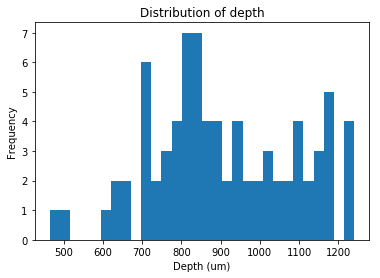

In [35]:
# Plot distribution of neuron depth 
plt.hist(units_df['depth'], bins=30)
plt.title('Distribution of depth')
plt.xlabel('Depth (um)')
plt.ylabel('Frequency')
plt.show()

We will compare the units that were recorded from 1165 um and 715 um cortical depths.

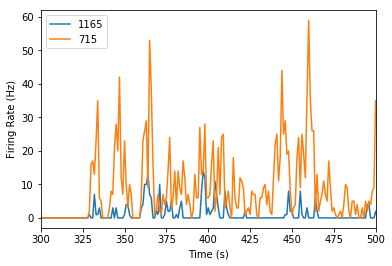

In [42]:
# Assign dataframes for different depths 
depth_1165 = units_df[units_df['depth']==1165]
depth_715 = units_df[units_df['depth']==715]

# Create list of containing 1 entry from each depth
neural_list_1165 = depth_1165['spike_times'].iloc[0]
neural_list_715 = depth_715['spike_times'].iloc[0]

# Plot firing rates
plot_firing_rates(neural_list_1165, 300, 500)
plot_firing_rates(neural_list_715, 300, 500)
plt.legend(['1165','715'])
plt.show()

It looks like the neuron that's more superficial has a higher firing rate! But we'd certainly need more data to make a conclusive argument about that.


## Additional resources

For more ideas about how to play with this dataset, see this [Github repository](https://github.com/vathes/DJ-NWB-Economo-2018/blob/master/notebooks/Economo-2018-examples.ipynb).